# Introduction #
Welcome. Let automate machine learning as much as possible.
<blockquote style="margin-right:auto; margin-left:auto; padding: 1em; margin:24px;">
    <strong>Fork This Notebook!</strong><br>
Create your own editable copy of this notebook by clicking on the <strong>Copy and Edit</strong> button in the top right corner.
</blockquote>

## Imports and Configuration ##

We'll start by importing the packages we used in the exercises and setting some notebook defaults. Unhide this cell if you'd like to see the libraries we'll use:

In [1]:
# from IPython.display import clear_output
!pip install -q -U autokeras==1.0.16.post1
# clear_output()

import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

# from category_encoders import MEstimateEncoder
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import autokeras as ak
import tensorflow as tf


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.18.0 requires tensorflow-io-gcs-filesystem==0.18.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.8.3 requires cupy-cuda114, which is not installed.
cudf 21.8.3 requires cupy-cuda110, which is not installed.
beatrix-jupyterlab 3.1.1 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.3.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.14.0 which is incompatible.
tfx-bsl 1.3.0 requires pyarrow<3,>=1, but you have pyarrow 5.0.0 which is incompatible.
tfx-bsl 1.3.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,<3,>=1.15.2, but you have tensorflow 2.5.2 which is incompatible.
tensorflow-transform 1.3.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.14.0 which is incompatible.
tensorflo

2021-12-03 03:55:20.427757: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Parameters


In [2]:
# -----------------------------------------------------------------
# Some parameters to config 
MAX_TRIAL = 5 # speed trial any%
EPOCHS = 80

# not used
BATCH_SIZE = 2048 # large enough to fit RAM
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
LABEL_SMOOTHING=1e-3
FOLDS = 5

RANDOM_STATE = 42
VERBOSE = 0

# The dataset is too huge for free contrainer. Sampling it for more fun!
SAMPLE = 195712 # [1468136, 2262087, 195712, 377, 1, 11426, 62261] # 4000000 total rows
VALIDATION_SPLIT = 0.15

# Admin
ID = "Id" # Id id x X index
INPUT = "../input/tabular-playground-series-dec-2021"

## Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. The data we used in the course was a bit simpler than the competition data. For the *Ames* competition dataset, we'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

In [3]:
def load_data():
    # Read data
    data_dir = Path(INPUT)
    df_train = pd.read_csv(data_dir / "train.csv", index_col=ID)
    df_test = pd.read_csv(data_dir / "test.csv", index_col=ID)
    # Merge the splits so we can process them together
#     df = pd.concat([df_train, df_test])
    # Preprocessing
#     df = clean(df)
#     df = encode(df)
    df_train = impute(df_train)
    df_test = impute(df_test)
    # Reform splits
#     df_train = df.loc[df_train.index, :]
#     df_test = df.loc[df_test.index, :]
    return df_train, df_test


### Handle Missing Values ###

Handling missing values now will make the feature engineering go more smoothly. We'll impute `0` for missing numeric values and `"None"` for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: `1` whenever a value was imputed and `0` otherwise.

In [4]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

## Load Data ##

And now we can call the data loader and get the processed data splits:

In [5]:
df_train, df_test = load_data()

In [6]:
# Peek at the values
display(df_train)
# display(df_test)

# Display information about dtypes and missing values
# display(df_train.info())
# display(df_test.info())

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
0,3189,40,8,30,13,3270,206,234,193,4873,...,0,0,0,0,0,0,0,0,0,1
1,3026,182,5,280,29,3270,233,240,106,5423,...,0,0,0,0,0,0,0,0,0,2
2,3106,13,7,351,37,2914,208,234,137,5269,...,0,0,0,0,0,0,0,0,0,1
3,3022,276,13,192,16,3034,207,238,156,2866,...,0,0,0,0,0,0,0,0,0,2
4,2906,186,13,266,22,2916,231,231,154,2642,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,2954,34,25,51,65,6314,240,237,103,1618,...,0,0,0,0,0,0,0,0,0,2
3999996,2926,104,8,696,83,5427,210,216,150,2863,...,0,0,0,0,0,0,0,0,0,2
3999997,2911,144,1,509,58,4820,195,192,91,92,...,0,0,0,0,0,0,0,1,0,2


In [7]:
target_col = df_train.columns.difference(df_test.columns)[0]
X_raw = df_train.drop(columns=target_col)
y_raw = df_train[target_col]

X_test_raw = df_test.iloc[:,:]
target_col

'Cover_Type'

# Resampling

Auto Keras y categories calculation wrong when cat 5 is missing etc

In [8]:
from sklearn.model_selection import train_test_split
# Check NA
missing_val = X_raw.isnull().sum()
print(missing_val[missing_val > 0])

# For small testing batch
# X_raw, x_val, y, y_val = train_test_split(X_raw, y, train_size = VALIDATION_SPLIT, random_state = RANDOM_STATE)
# X_raw = X_raw.sample(n=SAMPLE, random_state=RANDOM_STATE)
# y_raw = y_raw.sample(n=SAMPLE, random_state=RANDOM_STATE)
# x_test = x_test.sample(n=SAMPLE, random_state=RANDOM_STATE)

Series([], dtype: int64)


In [9]:
sampling_key, sampling_count = np.unique(y_raw, return_counts=True)
sampling_count[sampling_count > SAMPLE] = SAMPLE
zip_iterator = zip(sampling_key, sampling_count)
sampling_params = dict(zip_iterator)

undersample = RandomUnderSampler(
    sampling_strategy=sampling_params)

X_raw, y_raw = undersample.fit_resample(X_raw, y_raw)

In [10]:
np.unique(y_raw, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7]),
 array([195712, 195712, 195712,    377,      1,  11426,  62261]))

## Scaler transformer

In [11]:
transformer_all_cols = make_pipeline(
    RobustScaler(),
)

preprocessor = make_column_transformer(
    (transformer_all_cols, df_test.columns[:]),
)

In [12]:
X_train = preprocessor.fit_transform(X_raw)
X_test = preprocessor.transform(X_test_raw)

TPS always have huge dataset.

In [13]:
import gc
gc.collect()

132

# Hyperparameter Tuning #

At this stage, you might like to do auto hyperparameter tuning with AutoKeras before creating your final submission.
AutoKeras: An AutoML system based on Keras. It is developed by DATA Lab at Texas A&M University. The goal of AutoKeras is to make machine learning accessible to everyone.

By default, AutoKeras use the last 20% of training data as validation data. As shown in the example below, you can use validation_split to specify the percentage.

In [14]:
# Search for the best model with EarlyStopping.
cbs = [
    tf.keras.callbacks.EarlyStopping(patience=3),
]

In [15]:
# Initialize the structured data classifier.
clf = ak.StructuredDataClassifier(
    overwrite=False, max_trials=MAX_TRIAL,seed=RANDOM_STATE
)  # It tries MAX_TRIAL different models.
# Feed the structured data classifier with training data.
history = clf.fit(
                X_train,
                y_raw,
                # Split the training data and use the last 15% as validation data.
                validation_split=VALIDATION_SPLIT,
                epochs=EPOCHS,
                callbacks=cbs,
)



Trial 5 Complete [00h 23m 29s]
val_accuracy: 0.2530231177806854

Best val_accuracy So Far: 0.2530231177806854
Total elapsed time: 01h 58m 08s
Epoch 1/80
20663/20663 [==============================] - 89s 4ms/step - loss: 0.0565 - accuracy: 0.9929
Epoch 2/80
20663/20663 [==============================] - 91s 4ms/step - loss: 0.0564 - accuracy: 0.9936
Epoch 3/80
20663/20663 [==============================] - 92s 4ms/step - loss: 0.0557 - accuracy: 0.9945
Epoch 4/80
20663/20663 [==============================] - 94s 5ms/step - loss: 0.0569 - accuracy: 0.9941
Epoch 5/80
20663/20663 [==============================] - 96s 5ms/step - loss: 0.0676 - accuracy: 0.9939
Epoch 6/80
20663/20663 [==============================] - 91s 4ms/step - loss: 0.0524 - accuracy: 0.9945
Epoch 7/80
20663/20663 [==============================] - 94s 5ms/step - loss: 0.0642 - accuracy: 0.9943
Epoch 8/80
20663/20663 [==============================] - 96s 5ms/step - loss: 0.0487 - accuracy: 0.9950
Epoch 9/80
20663/2

2021-12-03 08:50:23.338538: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [16]:
# clf.evaluate(X_val, y_val)

You can also export the best model found by AutoKeras as a Keras Model.

In [17]:
model = clf.export_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 54)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 54)                0         
_________________________________________________________________
normalization (Normalization (None, 54)                109       
_________________________________________________________________
dense (Dense)                (None, 32)                1760      
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

# Train Model and Create Submissions #

Once you're satisfied with everything, it's time to create your final predictions! This cell will:
- use the best trained model to make predictions from the test set
- save the predictions to a CSV file

In [18]:
# Predict with the best model.
predicted_y = clf.predict(X_test)


31250/31250 [==============================] - 131s 4ms/step


In [19]:
predicted_y

array([['7'],
       ['7'],
       ['7'],
       ...,
       ['7'],
       ['7'],
       ['7']], dtype='<U1')

In [20]:
# output = pd.DataFrame({'Id': X_test.index, target_col: predicted_y})
output = pd.read_csv(INPUT + "/sample_submission.csv")
output[target_col] = predicted_y
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
output

Your submission was successfully saved!


,Id,Cover_Type
0,4000000,7
1,4000001,7
2,4000002,7
3,4000003,7
4,4000004,7
...,...,...
999995,4999995,7
999996,4999996,7
999997,4999997,7
999998,4999998,7


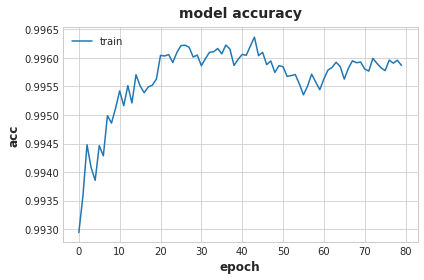

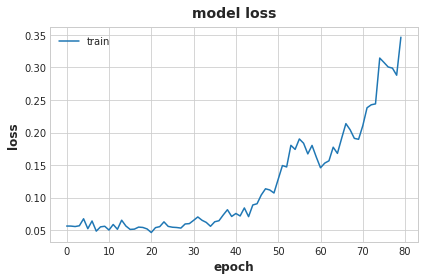

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
history.history

{'loss': [0.05646214261651039,
  0.056414537131786346,
  0.05570828542113304,
  0.05689549818634987,
  0.06763437390327454,
  0.05241377279162407,
  0.06422556191682816,
  0.048665765672922134,
  0.05521031841635704,
  0.056128278374671936,
  0.05033748969435692,
  0.05886128544807434,
  0.05148663744330406,
  0.06544497609138489,
  0.05651254579424858,
  0.05130130425095558,
  0.05171382054686546,
  0.05483546108007431,
  0.05432238057255745,
  0.052065204828977585,
  0.04651273041963577,
  0.054047901183366776,
  0.05554380640387535,
  0.06290266662836075,
  0.0559367910027504,
  0.05466409772634506,
  0.05422866344451904,
  0.05335390567779541,
  0.05963755398988724,
  0.060214556753635406,
  0.06517478823661804,
  0.0704144835472107,
  0.06532062590122223,
  0.0620291605591774,
  0.05608352646231651,
  0.06302493810653687,
  0.06462043523788452,
  0.07339450716972351,
  0.08151844888925552,
  0.07117187231779099,
  0.0757240504026413,
  0.0719384029507637,
  0.08423089981079102,
  

In [23]:
np.unique(output[target_col], return_counts=True)

(array(['1', '2', '3', '4', '6', '7'], dtype=object),
 array([  3357,   2353,   1018,   3264,   7509, 982499]))

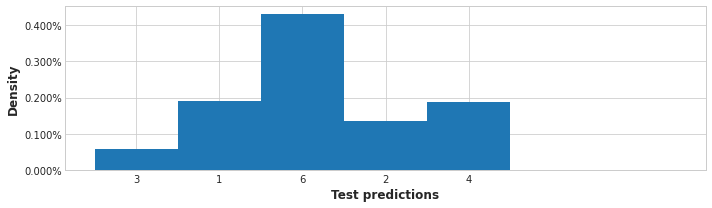

In [24]:
# Plot the distribution of the test predictions
plt.figure(figsize=(10,3))
plt.hist(output['Cover_Type'], bins=np.linspace(0.5, 7.5, 8), density=True)
plt.xlabel('Test predictions')
plt.ylabel('Density')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.show()

To submit these predictions to the competition, follow these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

# Next Steps #

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.

Be sure to check out [other users' notebooks](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/notebooks) in this competition. You'll find lots of great ideas for new features and as well as other ways to discover more things about the dataset or make better predictions. There's also the [discussion forum](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/discussion), where you can share ideas with other Kagglers.

Have fun Kaggling!